This code propagates a satellite in terms of slight variations in its initial orbital parameters, and stops the propagation when the satellite reaches 80km of altitude. The code then translates the initial Gaussian standard deviation into new uncertainties using the uscented transform mathematical formula. 

This part of the code initializes all the import that will be needed.

In [1]:
# The Gaussian class and unscented_transform used in this code are from:
# https://github.com/hugohadfield/unscented_transform

#setup all the imports needed for the code
import orekit
vm = orekit.initVM()
from math import radians
from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()
from org.orekit.orbits import OrbitType, KeplerianOrbit, PositionAngleType
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.utils import Constants, IERSConventions
from org.orekit.frames import FramesFactory
from org.orekit.propagation.numerical import NumericalPropagator
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.propagation import SpacecraftState
from org.orekit.propagation.events import AltitudeDetector
from org.orekit.propagation.events.handlers import StopOnEvent
from org.orekit.models.earth.atmosphere import NRLMSISE00
from org.orekit.forces.drag import DragForce, IsotropicDrag
from org.orekit.bodies import OneAxisEllipsoid, CelestialBodyFactory
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
from org.orekit.models.earth.atmosphere.data import MarshallSolarActivityFutureEstimation
from orekit import JArray_double
from mpl_toolkits.mplot3d import Axes3D


import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from unscented_transform import Gaussian, unscented_transform, plot_ellipse
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns

This part of the code will set up certain parameters and objects that will be needed later on.

In [2]:
#set the initial date
utc = TimeScalesFactory.getUTC()
gmst = TimeScalesFactory.getGMST(IERSConventions.IERS_2010, False)

epochDate = AbsoluteDate(2020, 1, 1, 0, 0, 00.000, utc)
initialDate = epochDate

#set our orbit/satellite parameters
rp = 150000.0
ra = 300000.0
i = radians(98.2)
omega = radians(0)
raan = radians(0)
lv = radians(0)
satellite_mass = 90.0
playerOne = [90, 1.1, 2.25]
Airbus = [500, [2.78,7.41], 2.25]

a = (rp + ra + 2 * Constants.WGS84_EARTH_EQUATORIAL_RADIUS) / 2.0    
e = 1.0 - (rp + Constants.WGS84_EARTH_EQUATORIAL_RADIUS) / a

#set up the inertial frame where the satellite is defined
inertialFrame = FramesFactory.getEME2000()

#set up the orbit construction as Keplerian
initialOrbit_0 = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngleType.TRUE,
                              inertialFrame, epochDate, Constants.WGS84_EARTH_MU)

#set up the Earth for the plotting of the orbit later on
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)
sun = CelestialBodyFactory.getSun()
msafe = MarshallSolarActivityFutureEstimation(MarshallSolarActivityFutureEstimation.DEFAULT_SUPPORTED_NAMES,
                                              MarshallSolarActivityFutureEstimation.StrengthLevel.AVERAGE)

Defines the function that transforms the initial Gaussian variation in the perigee and apogee radii into a Gaussian variation in the semi-major axis and the eccentricity.

In [3]:
def sigma_points(mean, covariance):
    def non_linear_function(x):
        a = (x[0] + x[1]) / 2.0
        e = 1.0 - (x[1]) / a
        return np.array([a, e])
    
    gaussian = Gaussian(mean, covariance)
    
    transformed_gaussian = unscented_transform(gaussian, non_linear_function)
    
    sigma_points = gaussian.compute_sigma_points()
    transformed_sigma_points = [non_linear_function(sp) for sp in sigma_points]
    return transformed_sigma_points, transformed_gaussian

Defines the main function of the code that will propagate the initial orbital parameters of the satellite until it reaches an altitude of 80km above Earth.

In [4]:
def numerical_propagation(x):
    initialOrbit = KeplerianOrbit(float(x[0]),
                                    float(x[1]),
                                i, omega, raan, lv, PositionAngleType.TRUE,
                              inertialFrame, initialDate.shiftedBy(float(x[2])), Constants.WGS84_EARTH_MU)
    #set up the code for the numerical propagation ( use of integrator, tolerances)
    minStep = 0.0001
    maxstep = 1000.0
    initStep = 10.0

    positionTolerance = 0.01

    tolerances = NumericalPropagator.tolerances(positionTolerance, 
                                                initialOrbit, 
                                                initialOrbit.getType())

    integrator = DormandPrince853Integrator(minStep, maxstep, 
        JArray_double.cast_(tolerances[0]),
        JArray_double.cast_(tolerances[1]))
    integrator.setInitialStepSize(initStep)

    #set up the propagator
    initialState = SpacecraftState(initialOrbit, satellite_mass) 
    propagator_num = NumericalPropagator(integrator)
    propagator_num.setOrbitType(OrbitType.CARTESIAN)
    propagator_num.setInitialState(initialState)
    altitude_detector = AltitudeDetector(80000.0, earth).withHandler(StopOnEvent())
    propagator_num.addEventDetector(altitude_detector)
    atmosphere = NRLMSISE00(msafe, sun, earth)
    drag_model = IsotropicDrag(playerOne[1], float(x[3]*playerOne[2]))
    drag_force = DragForce(atmosphere, drag_model)
    propagator_num.addForceModel(drag_force)

    gravityProvider = GravityFieldFactory.getNormalizedProvider(10, 10)
    propagator_num.addForceModel(HolmesFeatherstoneAttractionModel(FramesFactory.getITRF(IERSConventions.IERS_2010, True), gravityProvider))
    finalDate = initialDate.shiftedBy(float(duration))
    final_state = propagator_num.propagate(initialDate, finalDate)
    pv = final_state.getPVCoordinates()
    OrbitType.CARTESIAN.convertType(propagator_num.getInitialState().getOrbit())
    orbit = final_state.getOrbit()
    keplerian_orbit = KeplerianOrbit(orbit)

    return pv, final_state, keplerian_orbit

This part of the code defines the size of the initial variations, the number of samples that will be taken, and plots the semi-major axis and eccentricity Gaussian variation.

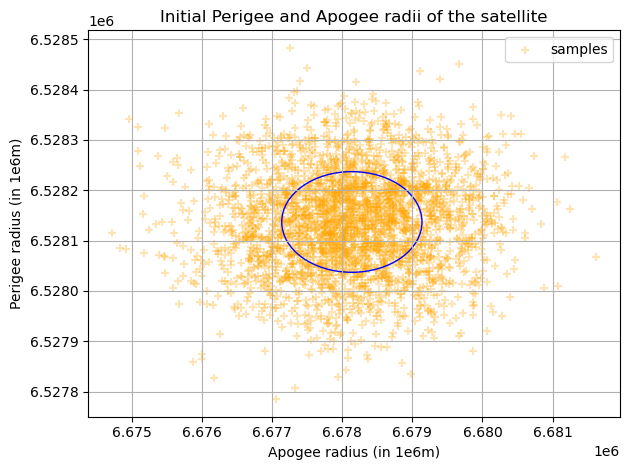

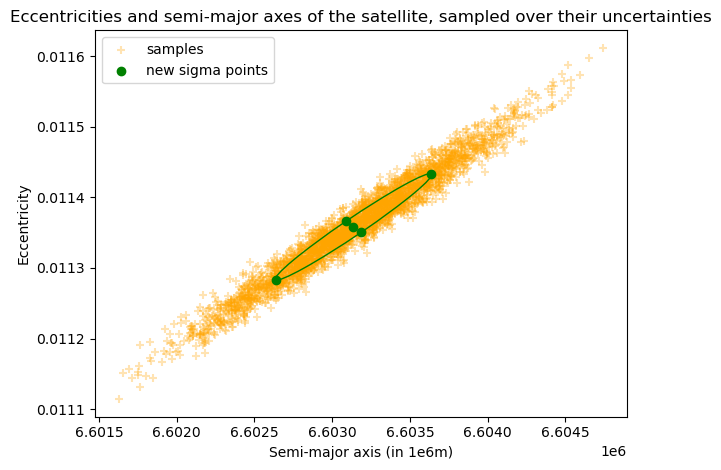

In [5]:
duration = 4*24*3600
sigma_rp = 100.0
sigma_ra = 1000.0
sigma_t = np.radians(0.5)/Constants.WGS84_EARTH_ANGULAR_VELOCITY
sigma_k = 0.01
mean = np.array([ra+Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                  rp+Constants.WGS84_EARTH_EQUATORIAL_RADIUS])
covariance = np.array([[sigma_ra**2, 0.0], [0.0, sigma_rp**2]])
initialgaussian = Gaussian(mean, covariance)

N = 100
rp_ra_samples = np.random.multivariate_normal(mean, covariance, size=N)

# Step 2: Transform each sample to (a, e)
a_samples = (rp_ra_samples[:, 0] + rp_ra_samples[:, 1]) / 2
e_samples = (rp_ra_samples[:, 0] - rp_ra_samples[:, 1]) / (rp_ra_samples[:, 1] + rp_ra_samples[:, 0])

ae_samples = np.vstack([a_samples, e_samples]).T

# Step 3: Estimate new mean and covariance
mu_ae = np.mean(ae_samples, axis=0)
covariance_ae = np.cov(ae_samples, rowvar=False)

num_samples = 3000

sig_rpra = initialgaussian.compute_sigma_points()
rpra_ellipse_samples = [initialgaussian.sample() for _ in range(num_samples)]
x_rpra = [item[0] for item in rpra_ellipse_samples]
y_rpra = [item[1] for item in rpra_ellipse_samples]


sig_ae, gaussian_ae = sigma_points(mean, covariance)
#print(gaussian_ae.covariance())
#print(gaussian_ae.mean())
new_mean = np.zeros((4))
new_mean[:2] = gaussian_ae.mean()
new_mean[2] = 0.0
new_mean[3] = 1
new_covariance = np.zeros((4,4))
new_covariance[:2, :2] = gaussian_ae.covariance()
new_covariance[2, 2] = sigma_t**2
new_covariance[3, 3] = sigma_k**2
#print(new_covariance)
new_covariance[3,0] = 0
new_covariance[0,3] = 0
newgaussian = Gaussian(new_mean, new_covariance)
sig_points = newgaussian.compute_sigma_points()
weights = newgaussian.compute_weights()
samples = [newgaussian.sample() for _ in range(num_samples)]
samples[:0] = sig_points
#print(sig_points)
ae_ellipse_samples = [gaussian_ae.sample() for _ in range(num_samples)]
x_ae = [item[0] for item in ae_ellipse_samples]
y_ae = [item[1] for item in ae_ellipse_samples]

plt.figure()
ax = plt.gca()
plt.scatter(x_rpra, y_rpra, alpha = 0.3, color = 'orange', marker = '+', label = 'samples')
plot_ellipse(mean, covariance, ax, n_std=1, facecolor='none', edgecolor='blue')  
plt.title("Initial Perigee and Apogee radii of the satellite")
plt.xlabel("Apogee radius (in 1e6m)")
plt.ylabel("Perigee radius (in 1e6m)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure()
ax = plt.gca()
plt.scatter(x_ae, y_ae, alpha = 0.3, color = 'orange', marker = '+', label = 'samples')
plot_ellipse(gaussian_ae.mean(), gaussian_ae.covariance(), ax, n_std=1, facecolor='none', edgecolor='green')  
plt.scatter([x[0] for x in sig_ae], [x[1] for x in sig_ae], color='green', label = 'new sigma points')
plt.title("Eccentricities and semi-major axes of the satellite, sampled over their uncertainties")
plt.xlabel("Semi-major axis (in 1e6m)")
plt.ylabel("Eccentricity")
plt.legend()
plt.tight_layout()
plt.show()


Creates lists that will append the data obtained from the propagation. Propagation is done for each different sample, and the final data is recorded to be able to plot the variables and analyze them.

In [6]:
lat = []
lon = []
pa = []
time = []
positions = []
velocities = []
inc = []
ohm = []
LAN = []

for j in range(len(samples[:100])):
    pvs, final_state, final_state_orbit = numerical_propagation(samples[j])
    if j == 1:
        og_final_state = final_state_orbit
    v = pvs.getVelocity()
    p = pvs.getPosition()
    x = p.getX()
    y = p.getY()
    z = p.getZ()
    vx = v.getX()
    vy = v.getY()
    vz = v.getZ()
    position = [x, y, z]
    velocity = [vx, vy, vz]
    positions.append(position)
    velocities.append(velocity)
    t = initialDate.shiftedBy(float(final_state.getDate().durationFrom(initialDate)))
    RAAN = final_state_orbit.getRightAscensionOfAscendingNode()
    perig = final_state_orbit.getPerigeeArgument()
    incli = final_state_orbit.getI()
    trueano = final_state_orbit.getTrueAnomaly()
    pa.append(perig+trueano)
    time.append(final_state.getDate().durationFrom(initialDate)/3600)
    gmstSeconds = final_state.getDate().getComponents(gmst).getTime().getSecondsInLocalDay()
    sid_time = (gmstSeconds / 240.0) % 360.0
    LAN.append(np.radians(np.degrees(RAAN) - sid_time))
    inc.append(np.degrees(incli))
    ohm.append(np.degrees(RAAN))
    subpoint = earth.transform(p, inertialFrame, t)
    lat.append(np.degrees(subpoint.getLatitude()))
    lon.append(np.degrees(subpoint.getLongitude()))

This defines 2 functions that will be used later, which is the Gaussian formula and a function that will unwrap the alpha angles obtained to see a linear dependance with time.

In [7]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def unwrap_angles(perigee):
    unwrapped = [perigee[0]]
    print(unwrapped[0])
    for i in range(1, len(perigee)):
        delta = perigee[i] - perigee[i-1]

        if delta < -np.pi:
            unwrapped.append(unwrapped[-1] + (perigee[i] + 2*np.pi - perigee[i-1]))
        elif delta > np.pi:
            unwrapped.append(unwrapped[-1] + (perigee[i] - 2*np.pi - perigee[i-1]))
        else:
            unwrapped.append(unwrapped[-1] + delta)
    print(unwrapped[0])
    return unwrapped

def plot_ellipse(mean: np.ndarray, cov: np.ndarray, ax, n_std=1, num_points=900, **kwargs):

    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    theta = np.linspace(0, 2 * np.pi, num_points)
    ellipse_points = np.column_stack([
        ell_radius_x * np.cos(theta),
        ell_radius_y * np.sin(theta)
    ])

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])
    
    transformed_points = transf.transform(ellipse_points)

    ellipse_patch = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)
    ellipse_patch.set_transform(transf + ax.transData)
    ax.add_patch(ellipse_patch)

    return transformed_points

This plots the inclination and the right ascencion of the ascending node in terms of alpha. It shows a clear dependance, that we will be able to fit later on.

This part of the code will fit the inclination and RAAN data expressed in terms of the $\alpha$ angle. The fit is made using only the points calculated to determine the covariance of the resulting data using the unscented transform

Fitted inclination parameters (i0, i1, i2): [ 9.80022929e+01  1.09510496e-02 -1.84002481e-01]
Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂): [-0.27182137  0.06338477  0.00743875 -0.17809013]


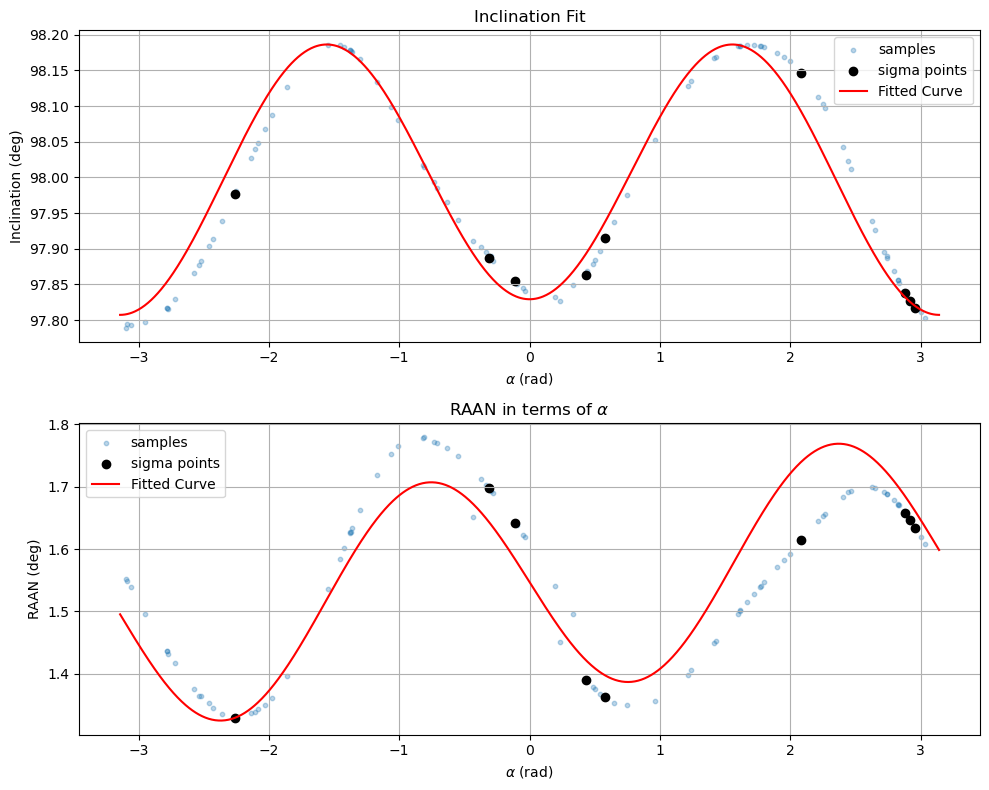

In [8]:
alpha_rad = pa
inc = np.array(inc)
def inclination_model(alpha, i0, i1, i2):
    return i0 + i1 * np.cos(alpha) + i2 * np.cos(2 * alpha)

def raan_model(data, omega0, omega_dot, omega1, omega2):
    alpha, t = data
    return omega0 + omega_dot * t + omega1 * np.sin(alpha) + omega2 * np.sin(2 * alpha)

max_index = np.argmax(alpha_rad)
min_index = np.argmin(alpha_rad)
zero_index = np.argmin(np.abs(alpha_rad))

new_indices = [0,1,2,3,4,5,6,7,8]
popt_i, _ = curve_fit(inclination_model, alpha_rad[:9], inc[:9])
print("Fitted inclination parameters (i0, i1, i2):", popt_i)

xdata = np.vstack((alpha_rad[:9], time[:9]))
popt_omega, _ = curve_fit(raan_model, xdata, ohm[:9])
print("Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂):", popt_omega)


alpha_fit = np.linspace(-np.pi, np.pi, 1000)
t_fit = np.linspace(min(time), max(time), 1000)

i_fit = inclination_model(alpha_fit, *popt_i)
omega_fit = raan_model((alpha_fit, t_fit), *popt_omega)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].scatter(alpha_rad, inc, s = 10, alpha = 0.3, label = 'samples')
axs[0].scatter(alpha_rad[:9], inc[:9], label='sigma points', color = 'black')
axs[0].plot(alpha_fit, i_fit, 'r', label='Fitted Curve')
axs[0].set_title("Inclination Fit")
axs[0].set_xlabel("$\\alpha$ (rad)")
axs[0].set_ylabel("Inclination (deg)")
axs[0].legend(loc = 'upper right')
axs[0].grid(True)

axs[1].scatter(alpha_rad, ohm, s = 10, alpha = 0.3, label = 'samples')
axs[1].scatter(alpha_rad[:9], ohm[:9], label='sigma points', color = 'black')
axs[1].plot(alpha_fit, omega_fit, 'r', label='Fitted Curve')
axs[1].set_title("RAAN in terms of $\\alpha$")
axs[1].set_xlabel("$\\alpha$ (rad)")
axs[1].set_ylabel("RAAN (deg)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


0.33432025592246406
0.33432025592246406


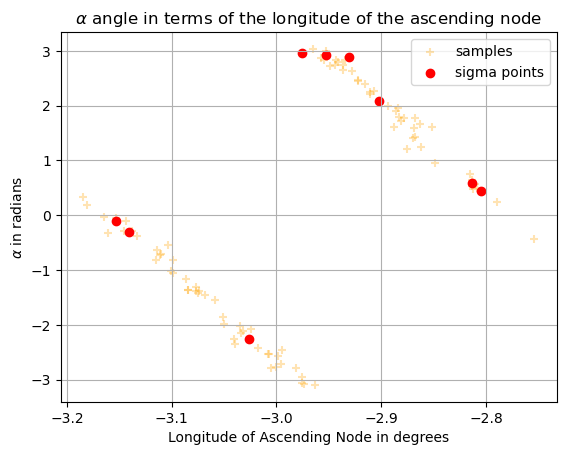

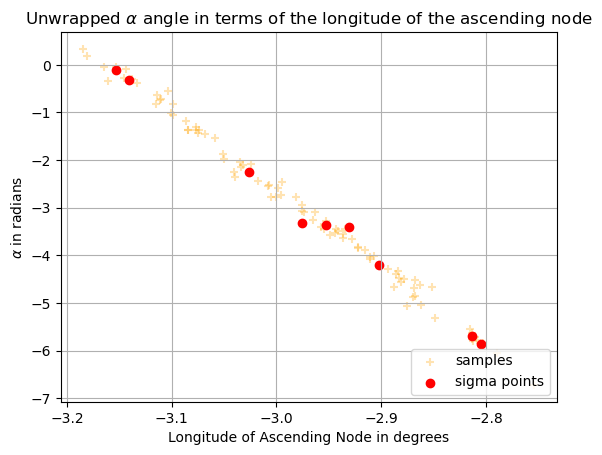

In [9]:
LAN = np.array(LAN)
pa = np.array(pa)
positions = np.array(positions)
ohm = np.array(ohm)
inc = np.array(inc)

sigma_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]
sorted_indices = np.argsort(LAN)
LAN_sorted = LAN[sorted_indices]
pa_sorted = pa[sorted_indices]
ohm_sorted = ohm[sorted_indices]
inc_sorted = inc[sorted_indices]
reverse_lookup = {orig_idx: new_idx for new_idx, orig_idx in enumerate(sorted_indices)}
sigma_sorted_indices = [reverse_lookup[i] for i in sigma_indices]
unwrapped_pa = np.array(unwrap_angles(pa_sorted))


plt.figure()
plt.scatter(LAN[9:], pa[9:], color = "orange", alpha = 0.3, marker = "+", label= 'samples')
plt.scatter(LAN[:9], pa[:9], color = "red", label= 'sigma points')
plt.title("$\\alpha$ angle in terms of the longitude of the ascending node")
plt.xlabel("Longitude of Ascending Node in degrees")
plt.ylabel("$\\alpha$ in radians")
plt.grid(True)
plt.legend(loc= 'upper right')
plt.show()

plt.figure()
plt.scatter(LAN_sorted, unwrapped_pa, color = "orange", alpha = 0.3, marker = "+", label = 'samples')
plt.scatter(LAN_sorted[sigma_sorted_indices], unwrapped_pa[sigma_sorted_indices], color = "red", label = 'sigma points')
plt.xlabel("Longitude of Ascending Node in degrees")
plt.ylabel("$\\alpha$ in radians")
plt.title("Unwrapped $\\alpha$ angle in terms of the longitude of the ascending node")
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

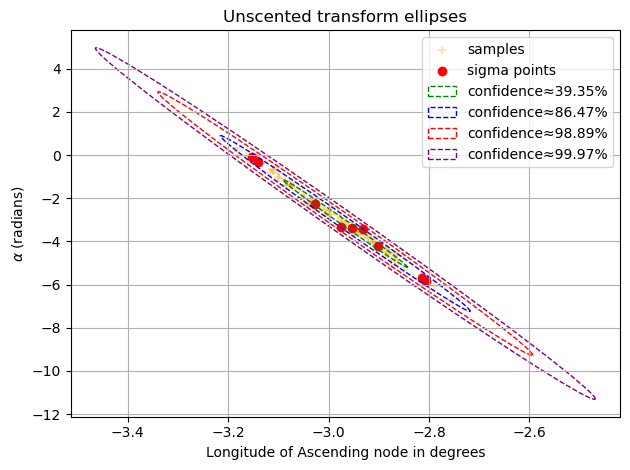

In [10]:
final_sig_points = [(t, x) for t, x in zip(LAN_sorted[sigma_sorted_indices], unwrapped_pa[sigma_sorted_indices])]
final_sig_points = np.array(final_sig_points)
final_sig_points = final_sig_points[np.argsort(final_sig_points[:, 0])]

final_mean = np.mean(final_sig_points, axis=0)
final_covariance = np.cov(final_sig_points, rowvar=False)

plt.figure()
ax = plt.gca()
plt.grid(True)
plt.scatter(LAN_sorted, unwrapped_pa, color = "orange", alpha = 0.3, marker = "+", label = 'samples')
plt.scatter(LAN_sorted[sigma_sorted_indices], unwrapped_pa[sigma_sorted_indices], color = "red", label = 'sigma points')

ellipse1_points = plot_ellipse(final_mean, final_covariance, ax, n_std=1, facecolor='none', edgecolor='green', linestyle = '--', label = 'confidence≈39.35%') 
ellipse2_points = plot_ellipse(final_mean, final_covariance, ax, n_std=2, facecolor='none', edgecolor='blue', linestyle = '--', label = 'confidence≈86.47%')
ellipse3_points = plot_ellipse(final_mean, final_covariance, ax, n_std=3, facecolor='none', edgecolor='red', linestyle = '--', label = 'confidence≈98.89%')  
ellipse4_points = plot_ellipse(final_mean, final_covariance, ax, n_std=4, facecolor='none', edgecolor='purple', linestyle = '--', label = 'confidence≈99.97%')  
plt.title("Unscented transform ellipses")
plt.xlabel("Longitude of Ascending node in degrees")
plt.ylabel("$\\alpha$ (radians)")
plt.legend()
plt.tight_layout()
plt.show()

This converts the velocities into spherical coordinates to see if there is any strong deviation from the current position as the satellite lands on Earth.

This part of the code will utilize the unwrapping angles function to unwrap the alpha angles obtained, and will then plot the original alpha in terms of time and the unwrapped alpha in terms of time.

This part of the code, I'll try to change it so the $\alpha$ angle doesn't vary from -$\pi$ to $\pi$, but instead is also unwrapped, to see if there is a better fit that can be obtained like that.

Fitted inclination parameters (i0, i1, i2): [ 9.80022928e+01  1.09517682e-02 -1.84002467e-01]
Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂): [ 1.59448555  0.0153152   0.00884468 -0.17717493]


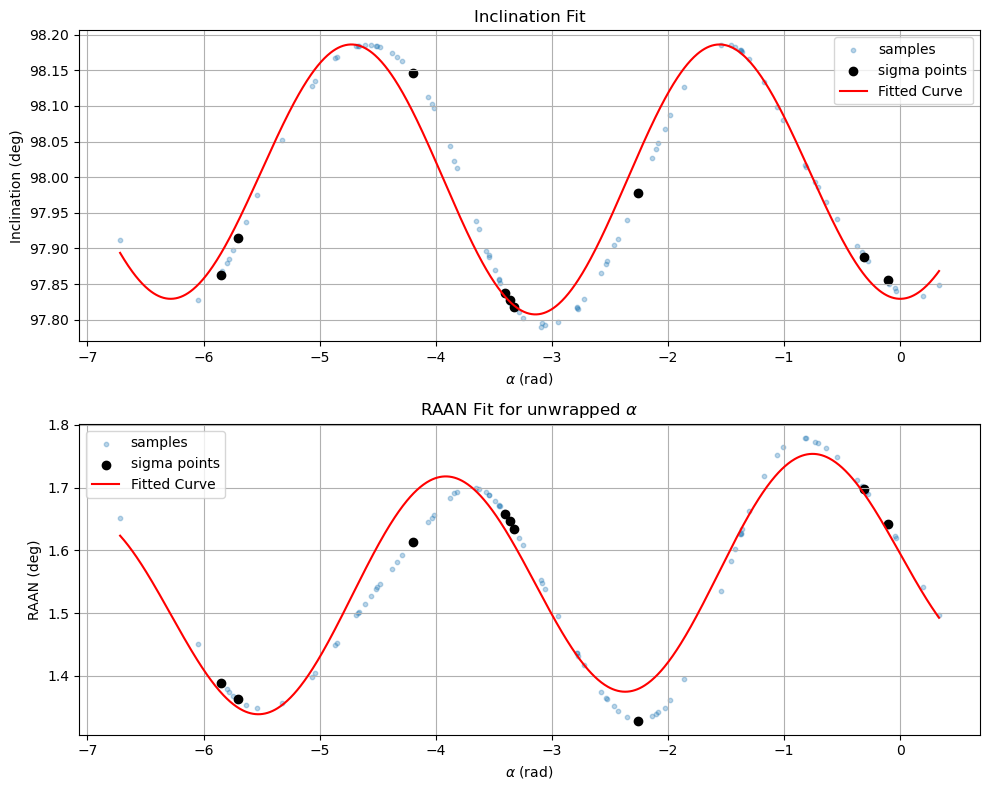

<Figure size 640x480 with 0 Axes>

In [11]:
alpha_rad = unwrapped_pa

def raan_model_unwrapped(alpha, omega0, omega_alpha, omega1, omega2):
    return omega0 + omega_alpha*alpha + omega1 * np.sin(alpha) + omega2 * np.sin(2 * alpha)

indices = sigma_sorted_indices.copy()

popt_i_unwrapped, _ = curve_fit(inclination_model, alpha_rad[sigma_sorted_indices], inc[:9])
print("Fitted inclination parameters (i0, i1, i2):", popt_i_unwrapped)


popt_omega_unwrapped, _ = curve_fit(raan_model_unwrapped, alpha_rad[sigma_sorted_indices], ohm[:9])
print("Fitted RAAN parameters (Ω₀, Ω̇, Ω₁, Ω₂):", popt_omega_unwrapped)

alpha_fit = np.linspace(min(alpha_rad), max(alpha_rad), 1000)
t_fit = np.linspace(min(time), max(time), 1000)

i_fit = inclination_model(alpha_fit, *popt_i_unwrapped)
omega_fit = raan_model_unwrapped(alpha_fit, *popt_omega_unwrapped)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].scatter(alpha_rad, inc_sorted, s = 10, alpha = 0.3, label = 'samples')
axs[0].scatter(alpha_rad[sigma_sorted_indices], inc_sorted[sigma_sorted_indices], label='sigma points', color = 'black')
axs[0].plot(alpha_fit, i_fit, 'r', label='Fitted Curve')
axs[0].set_title("Inclination Fit")
axs[0].set_xlabel("$\\alpha$ (rad)")
axs[0].set_ylabel("Inclination (deg)")
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(alpha_rad, ohm_sorted, s = 10, alpha = 0.3, label = 'samples')
axs[1].scatter(alpha_rad[sigma_sorted_indices], ohm_sorted[sigma_sorted_indices], label='sigma points', color = 'black')
axs[1].plot(alpha_fit, omega_fit, 'r', label='Fitted Curve')
axs[1].set_title("RAAN Fit for unwrapped $\\alpha$")
axs[1].set_xlabel("$\\alpha$ (rad)")
axs[1].set_ylabel("RAAN (deg)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

plt.figure()

raan_ell1 = [raan for raan in raan_model_unwrapped(ellipse1_points[:,1], popt_omega_unwrapped[0], popt_omega_unwrapped[1], popt_omega_unwrapped[2], popt_omega_unwrapped[3])]
raan_ell2 = [raan for raan in raan_model_unwrapped(ellipse2_points[:,1], popt_omega_unwrapped[0], popt_omega_unwrapped[1], popt_omega_unwrapped[2], popt_omega_unwrapped[3])]
raan_ell3 = [raan for raan in raan_model_unwrapped(ellipse3_points[:,1], popt_omega_unwrapped[0], popt_omega_unwrapped[1], popt_omega_unwrapped[2], popt_omega_unwrapped[3])]
raan_ell4 = [raan for raan in raan_model_unwrapped(ellipse4_points[:,1], popt_omega_unwrapped[0], popt_omega_unwrapped[1], popt_omega_unwrapped[2], popt_omega_unwrapped[3])]
#raan_samples = [raan for raan in raan_model_unwrapped(mapped_samples[:,1], popt_omega_unwrapped[0], popt_omega_unwrapped[1], popt_omega_unwrapped[2], popt_omega_unwrapped[3])]

This converts the ellipse points into latitudes and longitudes, by considering that only the time and perigee angles vary, which means that we take the mean satellite point and simply vary its initial parameters with the new perigee and time. This is obviously not correct, and is not a good way to approximate it, which is why we will be fitting the inclination and the right ascencion of the ascending node to determine better orbital parameters for the ellipse to determine its longitude and latitude.

In [ ]:
lan_ell1 = [lan for lan in ellipse1_points[:,0]]
lan_ell2 = [lan for lan in ellipse2_points[:,0]]
lan_ell3 = [lan for lan in ellipse3_points[:,0]]
lan_ell4 = [lan for lan in ellipse4_points[:,0]]


alpha_ell1 = [alpha for alpha in ellipse1_points[:,1]]
alpha_ell2 = [alpha for alpha in ellipse2_points[:,1]]
alpha_ell3 = [alpha for alpha in ellipse3_points[:,1]]
alpha_ell4 = [alpha for alpha in ellipse4_points[:,1]]

inc_ell1 = [np.radians(inc) for inc in inclination_model(ellipse1_points[:,1], popt_i_unwrapped[0], popt_i_unwrapped[1], popt_i_unwrapped[2])]
inc_ell2 = [np.radians(inc) for inc in inclination_model(ellipse2_points[:,1], popt_i_unwrapped[0], popt_i_unwrapped[1], popt_i_unwrapped[2])]
inc_ell3 = [np.radians(inc) for inc in inclination_model(ellipse3_points[:,1], popt_i_unwrapped[0], popt_i_unwrapped[1], popt_i_unwrapped[2])]
inc_ell4 = [np.radians(inc) for inc in inclination_model(ellipse4_points[:,1], popt_i_unwrapped[0], popt_i_unwrapped[1], popt_i_unwrapped[2])]

## Coordinates conversions
PSO and LAN $(\alpha,\Lambda)$ to latitude and longitude $(\phi,\lambda)$:
```python
r = p / (1 + ex*cos(α) + ey*sin(α))
x = r*cos(Λ)*cos(α) - r*sin(Λ)*cos(i)*sin(α)
y = r*sin(Λ)*cos(α) + r*cos(Λ)*cos(i)*sin(α)
z =                          r*sin(i)*sin(α)
λ = atan2(y,x)
ϕ = atan(z/sqrt(x²+y²)) = asin(z/r)
```



In [13]:
ell1_x = []
ell1_y = []
ell1_z = []
ell1_lat = []
ell1_lon = []
ell2_x = []
ell2_y = []
ell2_z = []
ell2_lat = []
ell2_lon = []
ell4_x = []
ell4_y = []
ell4_z = []
ell4_lat = []
ell4_lon = []
ell3_x = []
ell3_y = []
ell3_z = []
ell3_lat = []
ell3_lon = []

altitude = Constants.WGS84_EARTH_EQUATORIAL_RADIUS + 80000.0
for k in range(len(ellipse1_points)):

#Ellipse 1:

    x = altitude*np.cos(lan_ell1[k])*np.cos(alpha_ell1[k]) - altitude*np.sin(lan_ell1[k])*np.cos(inc_ell1[k])*np.sin(alpha_ell1[k])
    y = altitude*np.sin(lan_ell1[k])*np.cos(alpha_ell1[k]) + altitude*np.cos(lan_ell1[k])*np.cos(inc_ell1[k])*np.sin(alpha_ell1[k])
    z = altitude*np.sin(inc_ell1[k])*np.sin(alpha_ell1[k])
    lons = np.degrees(np.arctan2(y,x))
    lats = np.degrees(np.arctan(z/np.sqrt(x**2+y**2)))

    ell1_x.append(x)
    ell1_y.append(y)
    ell1_z.append(z)
    ell1_lat.append(lats)
    ell1_lon.append(lons)

#Ellipse 2:

    x = altitude*np.cos(lan_ell2[k])*np.cos(alpha_ell2[k]) - altitude*np.sin(lan_ell2[k])*np.cos(inc_ell2[k])*np.sin(alpha_ell2[k])
    y = altitude*np.sin(lan_ell2[k])*np.cos(alpha_ell2[k]) + altitude*np.cos(lan_ell2[k])*np.cos(inc_ell2[k])*np.sin(alpha_ell2[k])
    z = altitude*np.sin(inc_ell2[k])*np.sin(alpha_ell2[k])
    lons = np.degrees(np.arctan2(y,x))
    lats = np.degrees(np.arctan(z/np.sqrt(x**2+y**2)))

    ell2_x.append(x)
    ell2_y.append(y)
    ell2_z.append(z)
    ell2_lat.append(lats)
    ell2_lon.append(lons)

#Ellipse 3:

    x = altitude*np.cos(lan_ell3[k])*np.cos(alpha_ell3[k]) - altitude*np.sin(lan_ell3[k])*np.cos(inc_ell3[k])*np.sin(alpha_ell3[k])
    y = altitude*np.sin(lan_ell3[k])*np.cos(alpha_ell3[k]) + altitude*np.cos(lan_ell3[k])*np.cos(inc_ell3[k])*np.sin(alpha_ell3[k])
    z = altitude*np.sin(inc_ell3[k])*np.sin(alpha_ell3[k])
    lons = np.degrees(np.arctan2(y,x))
    lats = np.degrees(np.arctan(z/np.sqrt(x**2+y**2)))

    ell3_x.append(x)
    ell3_y.append(y)
    ell3_z.append(z)
    ell3_lat.append(lats)
    ell3_lon.append(lons)

#Ellipse 4:

    x = altitude*np.cos(lan_ell4[k])*np.cos(alpha_ell4[k]) - altitude*np.sin(lan_ell4[k])*np.cos(inc_ell4[k])*np.sin(alpha_ell4[k])
    y = altitude*np.sin(lan_ell4[k])*np.cos(alpha_ell4[k]) + altitude*np.cos(lan_ell4[k])*np.cos(inc_ell4[k])*np.sin(alpha_ell4[k])
    z = altitude*np.sin(inc_ell4[k])*np.sin(alpha_ell4[k])
    lons = np.degrees(np.arctan2(y,x))
    lats = np.degrees(np.arctan(z/np.sqrt(x**2+y**2)))

    ell4_x.append(x)
    ell4_y.append(y)
    ell4_z.append(z)
    ell4_lat.append(lats)
    ell4_lon.append(lons)



In [14]:

alt = np.array([80]*len(ell1_lon))
elx = (alt+6378) * np.cos(np.radians(ell1_lat)) * np.cos(np.radians(ell1_lon))
ely = (alt+6378) * np.cos(np.radians(ell1_lat)) * np.sin(np.radians(ell1_lon))
elz = (alt+6378) * np.sin(np.radians(ell1_lat))


import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=elx,y=ely,z=elz,
                                   mode='markers',marker=dict(size=5, color='blue', opacity=0.7))])


latitudes = np.arange(-90, 91, 10)
for lati in latitudes:
    lat_x = np.cos(np.radians(lati)) * np.cos(np.radians(np.linspace(0, 360, 100))) * 6371
    lat_y = np.cos(np.radians(lati)) * np.sin(np.radians(np.linspace(0, 360, 100))) * 6371
    lat_z = np.full_like(lat_x, 6371 * np.sin(np.radians(lati)))
    
    fig.add_trace(go.Scatter3d(x=lat_x, y=lat_y, z=lat_z,mode='lines',line=dict(color='green', width=2)))

longitudes = np.arange(-180, 181, 30)
for long in longitudes:
    lon_x = np.cos(np.radians(np.linspace(-90, 90, 100))) * np.cos(np.radians(long)) * 6371
    lon_y = np.cos(np.radians(np.linspace(-90, 90, 100))) * np.sin(np.radians(long)) * 6371
    lon_z = np.sin(np.radians(np.linspace(-90, 90, 100))) * 6371
    
    fig.add_trace(go.Scatter3d(x=lon_x, y=lon_y, z=lon_z,mode='lines',line=dict(color='red', width=2)))

fig.update_layout(scene=dict(xaxis_title="X",yaxis_title="Y",zaxis_title="Z"))
fig.write_html("satellite_plot.html")
fig.show()


This creates the ground track for visualisation of the satellite points and the ellipse points. There is a clear issue stemming from the ellipse points as they do not encase the points well enough. This must be due to the code directly inputting the $\alpha$ angle in as the perigee angle, when it is a combination of the perigee and the true anomaly. Will get back to this soon.

Text(0.5, 1.0, 'World Map')

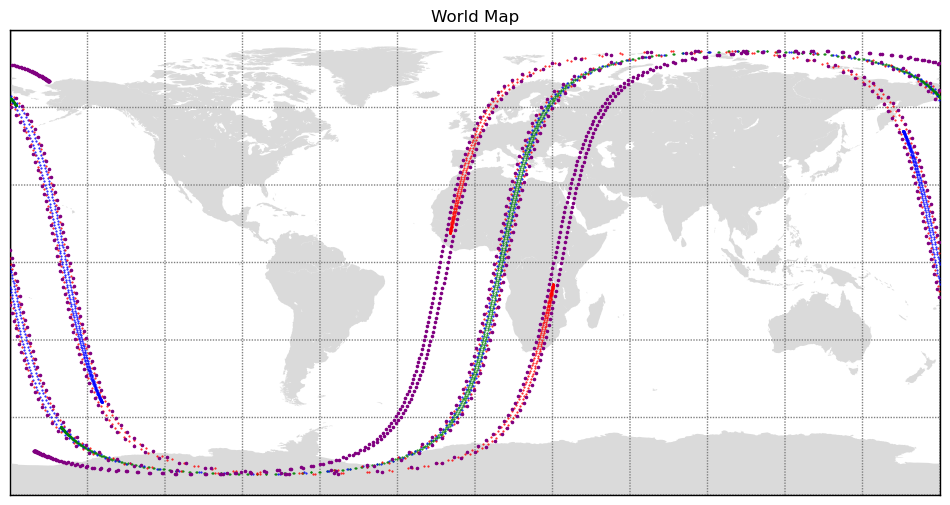

In [15]:
fig = plt.figure(figsize=(12, 10))
m = Basemap(projection='cyl',
            resolution='l',
            area_thresh=None)

m.drawmapboundary()
m.fillcontinents(color='#dadada', lake_color='white')
m.drawmeridians(np.arange(-180, 180, 30), color='gray')
m.drawparallels(np.arange(-90, 90, 30), color='gray')
#m.scatter(lon, lat, s = 10, color = 'red', zorder= 3, marker = '.')
m.scatter(ell1_lon, ell1_lat, s = 1, alpha = 1, color = 'green', zorder=3, marker= '.')
m.scatter(ell2_lon, ell2_lat, s = 1, alpha = 1, color = 'blue', zorder=3, marker='.')
m.scatter(ell3_lon, ell3_lat, s = 1, alpha = 1, color = 'red', zorder=3, marker='.')
m.scatter(ell4_lon, ell4_lat, s = 10, alpha = 1, color = 'purple', zorder=3, marker='.')
plt.title("World Map")


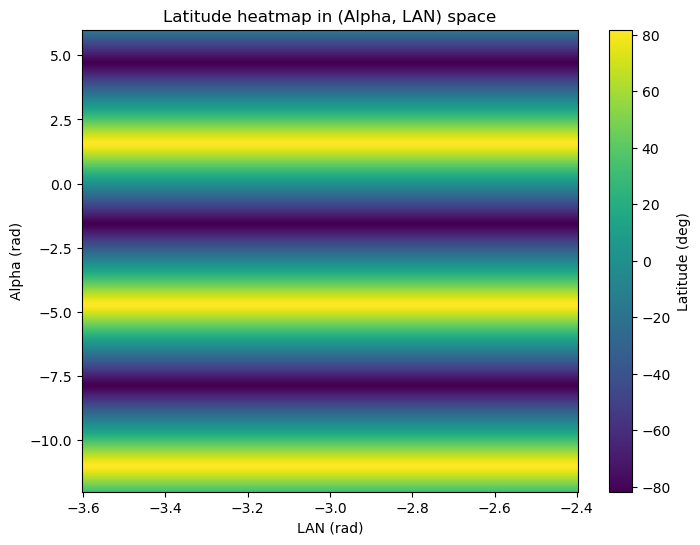

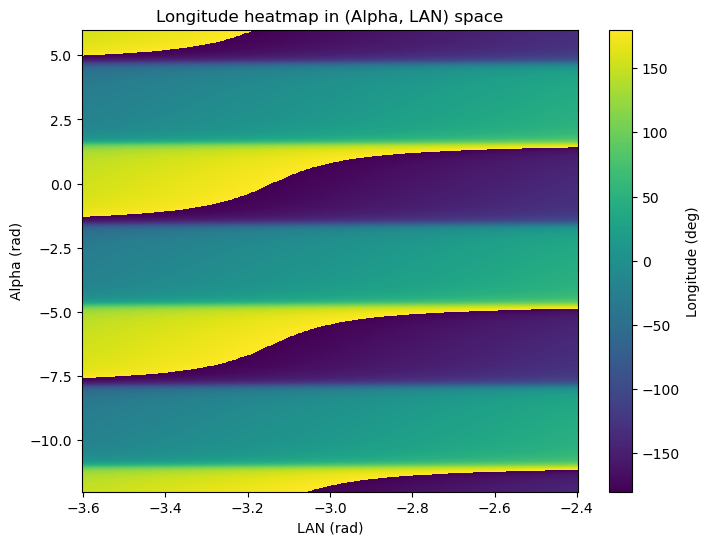

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define ranges for alpha and LAN
alpha_min, alpha_max, alpha_step = -12, 6, 0.005   # radians
LAN_min, LAN_max, LAN_step = -3.6, -2.4, 0.005

alpha_vals = np.arange(alpha_min, alpha_max, alpha_step)
LAN_vals = np.arange(LAN_min, LAN_max, LAN_step)

# Step 2: Build 2D meshgrid
LAN_grid, alpha_grid = np.meshgrid(LAN_vals, alpha_vals)

# Step 3: Compute latitude at each (LAN, alpha)
# Replace this with your actual formula
def compute_latitude(alpha, LAN):
    alpha_inc = np.radians(inclination_model(alpha, popt_i_unwrapped[0], popt_i_unwrapped[1], popt_i_unwrapped[2]))
    x = altitude*np.cos(LAN)*np.cos(alpha) - altitude*np.sin(LAN)*np.cos(alpha_inc)*np.sin(alpha)
    y = altitude*np.sin(LAN)*np.cos(alpha) + altitude*np.cos(LAN)*np.cos(alpha_inc)*np.sin(alpha)
    z = altitude*np.sin(alpha_inc)*np.sin(alpha)
    lat = np.degrees(np.arctan(z/np.sqrt(x**2+y**2)))
    return lat

def compute_longitude(alpha, LAN):
    alpha_inc = np.radians(inclination_model(alpha, popt_i_unwrapped[0], popt_i_unwrapped[1], popt_i_unwrapped[2]))
    x = altitude*np.cos(LAN)*np.cos(alpha) - altitude*np.sin(LAN)*np.cos(alpha_inc)*np.sin(alpha)
    y = altitude*np.sin(LAN)*np.cos(alpha) + altitude*np.cos(LAN)*np.cos(alpha_inc)*np.sin(alpha)
    z = altitude*np.sin(alpha_inc)*np.sin(alpha)
    lon = np.degrees(np.arctan2(y,x))
    return lon 

lat_grid = compute_latitude(alpha_grid, LAN_grid)
lon_grid = compute_longitude(alpha_grid, LAN_grid)

# Step 4: Plot heatmap
plt.figure(figsize=(8, 6))
plt.pcolormesh(LAN_vals, alpha_vals, lat_grid, cmap="viridis", shading="auto")
plt.colorbar(label="Latitude (deg)")
plt.xlabel("LAN (rad)")
plt.ylabel("Alpha (rad)")
plt.title("Latitude heatmap in (Alpha, LAN) space")
plt.show()

plt.figure(figsize=(8, 6))
plt.pcolormesh(LAN_vals, alpha_vals, lon_grid, cmap="viridis", shading="auto")
plt.colorbar(label="Longitude (deg)")
plt.xlabel("LAN (rad)")
plt.ylabel("Alpha (rad)")
plt.title("Longitude heatmap in (Alpha, LAN) space")
plt.show()




## Population map

https://www.earthdata.nasa.gov/data/projects/gpw

The GPW files split the world in sector by latitude and longitude and give the population density for each sector.
Let $S_c$ be the casualty area of the spacecraft surviving debris. If the debris land on a sector of area S, population density $d$ (and thus population $N=Sd$), the probability of making at least 1 victim (i.e. at least 1 person is inside the casualty area) is
$$P(X \geq 1 | S) = 1 - \left(1 - \frac{S_c}{S}\right)^N \approx N\frac{S_c}{S} = S_c d$$
Beware of numerical issues since $S_c \ll S$, the approximated formula *might* actually be more accurate numerically.




In [17]:
ncols, nrows = 360, 145
xllcorner, yllcorner = -180.0, -60.0
cellsize = 1.0

values = []
with open("POP_100_2024_GPW_V4_UN_ext.asc", "r") as f:
    lines = f.readlines()[6:]
    for line in lines:
        values.extend(map(float, line.split()))

values = np.array(values).reshape((nrows, ncols))


longitudes = np.arange(xllcorner, xllcorner + ncols * cellsize, cellsize)
latitudes = np.arange(yllcorner, yllcorner + nrows * cellsize, cellsize)
latitudes = np.flip(latitudes)

coords_with_values = []
for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        coords_with_values.append(([lon, lat], values[i, j]))

print(coords_with_values[:3])


[([-180.0, 84.0], 0.0), ([-179.0, 84.0], 0.0), ([-178.0, 84.0], 0.0)]


## Casualty risk integration

We want to integrate the global probability of making at least one victim:
$$P(X \geq 1) = S_c\iint_S p(\alpha,\Lambda)d(\phi,\lambda)dS$$
Two approaches:
- Integrate over $S = \left\{(\alpha,\Lambda) \in \mathbb{R}^2 \right\}$ and convert $(\alpha,\Lambda)$ to $(\phi,\lambda)$ for each integration point to get the population density. The integration can be restricted to some $n\sigma$-ellipse, but some libraries can handle infinite integration intervals.
- Integrate over $S = \left\{(\phi,\lambda) \in \left[-\frac{\pi}{2},\frac{\pi}{2}\right] \times ]-\pi, \pi] \right\}$ and convert $(\phi,\lambda)$ to series of $(\alpha,\Lambda)$ to get the probability density. It sounds more difficult, but since the population map is already discretized in $(\phi,\lambda)$, the conversion to $(\alpha,\Lambda)$ can be done once for each data point and reused for each subsequent casualty risk computation.

In [18]:
from scipy import *
from scipy.integrate import dblquad
from scipy.stats import multivariate_normal

def shift_integrand(integrand, offset):

    def dec(x, y):
        return integrand(x - offset[0], y - offset[1])

    return dec


# Wrapper for dblquad
def my_dblquad(func, xbounds, ybounds, midpoint=None, **kwargs):

    if midpoint is None:
        func = shift_integrand(func, (midpoint[0], midpoint[1]))

    return dblquad(func, xbounds[0], xbounds[1], ybounds[0], ybounds[1], **kwargs)



## Casualty risk integration

We want to integrate the global probability of making at least one victim:
$$P(X \geq 1) = S_c\iint_S p(\alpha,\Lambda)d(\phi,\lambda)dS$$

Integrate over $S = \left\{(\phi,\lambda) \in \left[-\frac{\pi}{2},\frac{\pi}{2}\right] \times ]-\pi, \pi] \right\}$ and convert $(\phi,\lambda)$ to series of $(\alpha,\Lambda)$ to get the probability density. It sounds more difficult, but since the population map is already discretized in $(\phi,\lambda)$, the conversion to $(\alpha,\Lambda)$ can be done once for each data point and reused for each subsequent casualty risk computation.

Latitude and longitude $(\phi,\lambda)$ to PSO and LAN $(\alpha,\Lambda)$:
```python
z/r = sin(i)sin(α) = sin(ϕ)
x/r = cos(λ) = cos(Λ)cos(α) - sin(Λ)cos(i)sin(α)
y/r = sin(λ) = sin(Λ)cos(α) + cos(Λ)cos(i)sin(α)
```
$$
\alpha = (-1)^k \arcsin(\frac{\sin\phi}{\sin i}) + k\pi
$$
$$
\alpha = \begin{cases}
&\arcsin(\frac{\sin\phi}{\sin i}) &+& 2k\pi\\
&\pi-\arcsin(\frac{\sin\phi}{\sin i}) &+ &2k\pi
\end{cases}
$$
$$
\Lambda(\alpha) = \text{atan2}(\frac{\cos\alpha \sin\lambda - \cos i \sin\alpha \cos\lambda}{1-\sin^2\phi}, \frac{\cos\alpha \cos\lambda + \cos i \sin\alpha \sin\lambda}{1-\sin^2\phi}) + 2k\pi
$$
Thus we have 2 series coordinates $(\alpha + 2n\pi,\Lambda(\alpha) + 2m\pi)$ for $\alpha = \arcsin(\frac{\sin\phi}{\sin i})$ and $\alpha = \pi - \arcsin(\frac{\sin\phi}{\sin i})$ and $m,n \in \mathbb{Z}$  

In [19]:
inc = np.radians(97.98)
casualty_area = 1
rv = multivariate_normal(mean=final_mean, cov=final_covariance)


def integral_function2(latitude, longitude, n_and_m):
    # Compute base alphas
    alpha1 = np.arcsin(np.sin(latitude) / np.sin(inc))
    alpha2 = np.pi - alpha1

    # Build arrays of n and m
    rng = np.arange(-n_and_m, n_and_m + 1)
    n_grid, m_grid = np.meshgrid(rng, rng, indexing="ij")

    # Flatten into 1D arrays
    n_vals = n_grid.ravel()
    m_vals = m_grid.ravel()

    # Two alpha branches (vectorized)
    alpha_branch1 = alpha1 + 2 * np.pi * n_vals
    alpha_branch2 = alpha2 + 2 * np.pi * n_vals

    # Concatenate both branches
    alphas = np.concatenate([alpha_branch1, alpha_branch2])
    m_vals = np.concatenate([m_vals, m_vals])  # match alphas length

    # Compute λ for all alphas at once
    num = np.cos(alphas) * np.sin(longitude) - np.cos(inc) * np.sin(alphas) * np.cos(longitude)
    den = np.cos(alphas) * np.cos(longitude) + np.cos(inc) * np.sin(alphas) * np.sin(longitude)
    lans = np.arctan2(num, den)

    # Add 2πm shifts
    lans += 2 * np.pi * m_vals

    # Evaluate PDF in bulk
    points = np.column_stack([lans, alphas])
    return np.sum(rv.pdf(points))


def integrate_cell(cell_bounds, n_and_m):
    lon_l, lon_r, lat_b, lat_t = cell_bounds

    # 2-point Gauss-Legendre nodes & weights
    nodes = np.array([-1 / np.sqrt(3), 1 / np.sqrt(3)])
    weights = np.array([1.0, 1.0])

    dlon = (lon_r - lon_l) / 2
    dlat = (lat_t - lat_b) / 2
    lon_mid = (lon_r + lon_l) / 2
    lat_mid = (lat_t + lat_b) / 2

    result = 0.0
    for i, xi in enumerate(nodes):
        for j, yj in enumerate(nodes):
            lon = lon_mid + dlon * xi
            lat = lat_mid + dlat * yj
            result += weights[i] * weights[j] * integral_function2(lat, lon, n_and_m)

    return result * dlon * dlat


def victim_risk(pop_value, n_and_m):
    casualty_prob = 0.0

    for cell in pop_value:
        (lon_deg, lat_deg), pop_density = cell
        if pop_density != 0.0 and lat_deg < 82.0:
            lon_left = np.radians(lon_deg)
            lon_right = np.radians(lon_deg + 1)
            lat_top = np.radians(lat_deg)
            lat_bottom = np.radians(lat_deg - 1)

            prob_mass = integrate_cell((lon_left, lon_right, lat_bottom, lat_top), n_and_m)
            casualty_prob += pop_density * prob_mass

    return casualty_prob


casualty_risk = casualty_area * victim_risk(coords_with_values, 0) / 1e6
print(f"There is a {casualty_risk*100:.4}% risk of a single victim with this reentry trajectory")
print("casualty_risk =", casualty_risk)


There is a 0.003526% risk of a single victim with this reentry trajectory
casualty_risk = 3.5260115952957466e-05


In [21]:
inc = np.radians(97.98)

rv = multivariate_normal(mean=final_mean, cov=final_covariance)

count = {"n": 0}
n_and_m = {"value": 3}


def integrand(lat, lon):
    count["n"] += 1

    #print("Step",count["n"],":","Latitude =", np.degrees(lat))
    #print("Longitude =", np.degrees(lon))
    
    alpha1 = np.arcsin(np.sin(lat)/np.sin(inc))
    alpha2 = np.pi - alpha1
    pdf_sum = 0.0

    # Build arrays of n and m
    rng = np.arange(-n_and_m["value"], n_and_m["value"] + 1)
    n_grid, m_grid = np.meshgrid(rng, rng, indexing="ij")

    # Flatten into 1D arrays
    n_vals = n_grid.ravel()
    m_vals = m_grid.ravel()

    # Two alpha branches (vectorized)
    alpha_branch1 = alpha1 + 2 * np.pi * n_vals
    alpha_branch2 = alpha2 + 2 * np.pi * n_vals

    # Concatenate both branches
    alphas = np.concatenate([alpha_branch1, alpha_branch2])
    m_vals = np.concatenate([m_vals, m_vals])  # match alphas length

    # Compute λ for all alphas at once
    num = np.cos(alphas) * np.sin(lon) - np.cos(inc) * np.sin(alphas) * np.cos(lon)
    den = np.cos(alphas) * np.cos(lon) + np.cos(inc) * np.sin(alphas) * np.sin(lon)
    lans = np.arctan2(num, den)

    # Add 2πm shifts
    lans += 2 * np.pi * m_vals

    # Evaluate PDF in bulk
    points = np.column_stack([lans, alphas])
    return np.sum(rv.pdf(points))
                
    #if pdf_sum < 1e-20:
    #    pdf_sum = 0.0

    return pdf_sum

def integrate_cell(cell_lat, cell_lon):

    lat_min = np.radians(cell_lat)
    lat_max = np.radians(cell_lat + 1)
    lon_min = np.radians(cell_lon)
    lon_max = np.radians(cell_lon + 1)

    integral, _ = dblquad(integrand, lon_min, lon_max, lambda _: lat_min, lambda _: lat_max, epsabs= 1e-8)
    print("Number of steps for this integral =", count["n"])
    count["n"] = 0
    print("Total Probability of the Integral =", integral)
    return integral

def total_casualty_risk(cells):
    total_risk = 0.0
    for lon_lat, pop_density in cells:
        print(lon_lat)
        lon, lat = lon_lat
        if pop_density != 0 and lat<82.0:
            cell_integral = integrate_cell(lat, lon)
            print("Population density =", pop_density)
            total_risk += pop_density * cell_integral
    return total_risk

casualty_risk = total_casualty_risk(coords_with_values)
print(casualty_risk)





[-180.0, 84.0]
[-179.0, 84.0]
[-178.0, 84.0]
[-177.0, 84.0]
[-176.0, 84.0]
[-175.0, 84.0]
[-174.0, 84.0]
[-173.0, 84.0]
[-172.0, 84.0]
[-171.0, 84.0]
[-170.0, 84.0]
[-169.0, 84.0]
[-168.0, 84.0]
[-167.0, 84.0]
[-166.0, 84.0]
[-165.0, 84.0]
[-164.0, 84.0]
[-163.0, 84.0]
[-162.0, 84.0]
[-161.0, 84.0]
[-160.0, 84.0]
[-159.0, 84.0]
[-158.0, 84.0]
[-157.0, 84.0]
[-156.0, 84.0]
[-155.0, 84.0]
[-154.0, 84.0]
[-153.0, 84.0]
[-152.0, 84.0]
[-151.0, 84.0]
[-150.0, 84.0]
[-149.0, 84.0]
[-148.0, 84.0]
[-147.0, 84.0]
[-146.0, 84.0]
[-145.0, 84.0]
[-144.0, 84.0]
[-143.0, 84.0]
[-142.0, 84.0]
[-141.0, 84.0]
[-140.0, 84.0]
[-139.0, 84.0]
[-138.0, 84.0]
[-137.0, 84.0]
[-136.0, 84.0]
[-135.0, 84.0]
[-134.0, 84.0]
[-133.0, 84.0]
[-132.0, 84.0]
[-131.0, 84.0]
[-130.0, 84.0]
[-129.0, 84.0]
[-128.0, 84.0]
[-127.0, 84.0]
[-126.0, 84.0]
[-125.0, 84.0]
[-124.0, 84.0]
[-123.0, 84.0]
[-122.0, 84.0]
[-121.0, 84.0]
[-120.0, 84.0]
[-119.0, 84.0]
[-118.0, 84.0]
[-117.0, 84.0]
[-116.0, 84.0]
[-115.0, 84.0]
[-114.0, 8

In [22]:
print(79985.88574983395/1e6)

0.07998588574983395
